In [1]:
# Import packages needed for case study
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set start date parameters
start_date = '2019-01-01'
end_date = '2022-07-15'

# list of renewable energy and greentech stocks
green_stocks_list = ['DNNGY', 'IBDRY', 'JKS', 'GCTAY', 'TSLA', 'BEP', 
 'FSLR','REGI','ENPH', 'NEE', 'AMRC', 'TTE', 'ON','MP', 'STEM', 'SEDG', 'CEIX', 'PBF', 'CWEN'
]

In [3]:
# create a dataframe from a specified list of stocks

def stocks_df(stock_list, start_date, end_date):
    stocks_dict = {}
    for stock in stock_list:
        stocks_dict[stock] = pdr.DataReader(stock, 'yahoo', start_date, end_date)['Adj Close']
        stocks_df = pd.DataFrame(data = stocks_dict)    
    return stocks_df


        

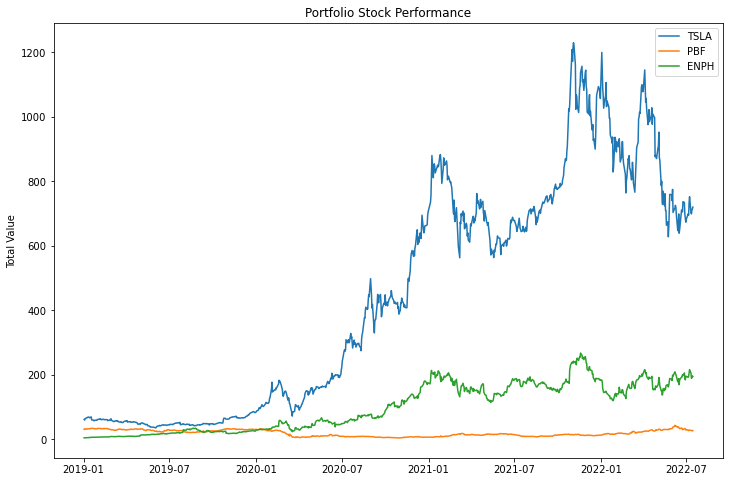

In [4]:
green_stocks = ['TSLA', 'PBF', 'ENPH']
green_stocks_df = stocks_df(green_stocks, start_date, end_date)


# View the selected stocks in the portfolio
def graph_stocks(stocks_df):
    plt.figure(figsize=(12, 8))
    plt.plot(stocks_df.iloc[:,0:len(stocks_df.columns)])
    plt.title('Portfolio Stock Performance')
    plt.ylabel('Total Value');
    plt.legend(stocks_df.columns)
    return 
graph_stocks(green_stocks_df)

In [5]:
green_stocks_df['TSLA'].iloc[0]

62.02399826049805

In [6]:
# graph of cumulative return of a $1 investment 

def graph_cumulative_return(stocks_data): 
    for stock in stocks_data.columns:
        print(stock)
        stocks_data[stock] = (stocks_data.pct_change()[[stock]] + 1).cumprod()
    plt.figure(figsize=(12, 8))
    plt.plot(stocks_data.iloc[:,0:len(stocks_data.columns)])
    plt.title('Stock Cumulative Sum')
    plt.ylabel('Growth of $1 Investment');
    plt.legend(stocks_data.columns)
    return 
    

In [7]:
# create function that returns the optimal portfolio weighting based on annualized sharpe ratio
import random
random.seed(3)
np.random.seed(3)

def optimal_portfolio(stock_data, num_scenarios):
    # empty weights array
    weights_array = np.zeros((num_scenarios,len(stock_data.columns)))
    # empty returns array
    returns_array = np.zeros(num_scenarios)
    # empty volatility array
    volatility_array = np.zeros(num_scenarios)
    # empty sharp ratio array 
    sharpe_array = np.zeros(num_scenarios)
    stock_data = stock_data.pct_change()
    # Import 10-year treasury bond data to get the risk free return
        
    treasury_bond = stocks_df(['^TNX'],start_date, end_date)
    treasury_bond = treasury_bond.pct_change()
    for index in range(num_scenarios):
        # generate  random numbers
        numbers = np.array(np.random.random(len(stock_data.columns)))
        
        # divide each number by the total to get the random weight
        weights = numbers / np.sum(numbers)
        
        # save weights in weights array 
        weights_array[index,:] = weights
        
        # calculate the return for each scenario
        returns_array[index] = np.sum(stock_data.mean()*weights)*252
        

        # note that this gives us the daily return of the portfolio based off the weighted
        
        # calculate the volatility for each portfolio
        volatility_array[index] = np.sqrt(np.dot(weights.T,np.dot(stock_data.cov()*252, weights)))
    
        # Calculate the Sharpe Ratio for each scenario 
        sharpe_array[index] = (returns_array[index] - treasury_bond.mean()*252) / volatility_array[index]
    print(sharpe_array.max())
    print(stock_data.columns)
    recommended_weights = weights_array[sharpe_array.argmax()]
    print(recommended_weights)
    volatility_of_rec_weight = volatility_array[sharpe_array.argmax()]
    stocks = np.array(stock_data.columns)
    
    dictionary = {'weight_array': weights_array,
                'returns_array': returns_array, 
                'volatility_array': volatility_array,
                'sharpe_array': sharpe_array,
               'stock names': stocks, 
               'rec_weights': recommended_weights,
               'Volatility Sharpe': volatility_of_rec_weight}
    return dictionary
# search up different ways of computing the sharpe ratio (such as using the monthly average return over yearly)


In [8]:
sample = optimal_portfolio(green_stocks_df, 1000)

1.3887783035464083
Index(['TSLA', 'PBF', 'ENPH'], dtype='object')
[0.37706377 0.00439275 0.61854348]


In [9]:
# return the stock weights for a random portfolio
sample['rec_weights']*10000

array([3770.63771517,   43.92745377, 6185.43483106])

In [10]:
# see portfolio performance using the weights given from the optimal portfolio algorithm
def portfolio_performance(stock_data, weights, value_portfolio): 
    len_cols = len(stock_data.columns)
    index_stockname = zip(range(0, len_cols), np.array(stock_data.columns))
    for index, stock_name in index_stockname:
        # normalized return : adjusted close / adjusted close on start date 
        stock_data[stock_name] = stock_data[stock_name] / stock_data[stock_name].iloc[0]
        # Allocation : normalized returns* optimal_weights
        stock_data[stock_name] = stock_data[stock_name]*weights[index]
        # Position Value : Allocation * 10000 (Value of Portfolio)
        stock_data[stock_name] = stock_data[stock_name]*value_portfolio
        #print(stock_data[stock_name])
    # create totals column
    stock_data['Totals'] = stock_data.sum(axis = 1)
    # view the total portfolio
    plt.figure(figsize=(12, 8))
    plt.plot(stock_data['Totals'])
    plt.title('Optimal-Weighted Portfolio Performance')
    plt.ylabel('Total Value');
    return stock_data


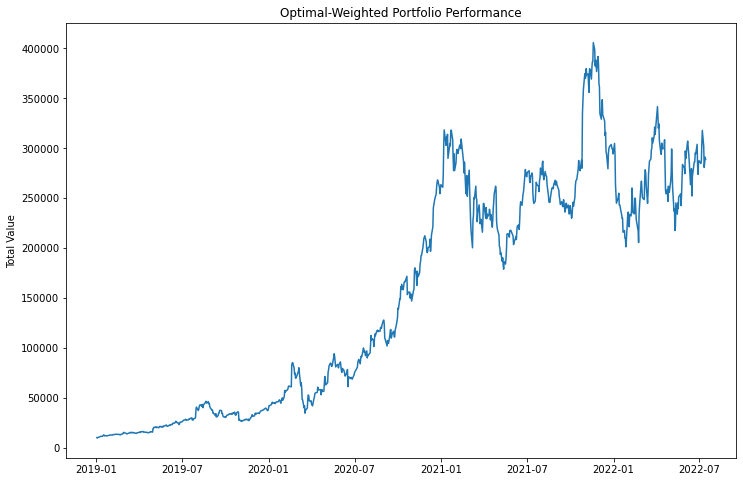

In [11]:
sample_2 = portfolio_performance(green_stocks_df, sample['rec_weights'], 10000)



In [12]:
sample_2

,TSLA,PBF,ENPH,Totals
Date,,,,
2019-01-02,3770.637715,43.927454,6185.434831,10000.000000
2019-01-03,3651.969397,42.527328,5984.282674,9678.779399
2019-01-04,3862.678626,44.372363,6386.586988,10293.637977
2019-01-07,4072.658273,44.751837,6612.883765,10730.293874
2019-01-08,4077.400321,43.822777,6726.031553,10847.254652
...,...,...,...,...
2022-07-11,42739.449531,39.051582,259059.078541,301837.579655
2022-07-12,42507.219038,38.403024,238202.098947,280747.721008
2022-07-13,43231.264491,37.036908,242174.862446,285443.163845


Function Calculated Performance Metrics after finding the optimal portfolio weightings and evaluating the performance of our portfolio** 
Cumulative Return, Mean Daily Return, Standard Deviation of Daily Return, Sharpe Ratio, Annualized Sharpe Ratio 

In [13]:
# performance metrics, note that the dataframe must be modified via portfolio performance

# returns a dictionary of the performance metrics
def performance_metrics(stock_data):
    # Define the end and start value of the portfolio
    end_value = stock_data['Totals'][-1]
    print(end_value)
    start_value = stock_data['Totals'][0]
    print(start_value)

    # Calculate the cumulative portfolio return as a percentage
    cumulative_return = end_value / start_value - 1

    print(str(round(cumulative_return*100,2)), '%')
    # Create a 'Daily Returns' column 
    stock_data['Daily Return'] = stock_data['Totals'].pct_change()
    
    # create mean daily return 
    mean_daily_return = stock_data['Daily Return'].mean()
    
    print('The mean daily return is:', str(round(mean_daily_return, 4)))
    
    # Calculate the standard deviation of Daily Returns 
    std_daily_return = stock_data['Daily Return'].std()
    
    print('The std daily return is: ', str(round(std_daily_return,4)))
    return {'cumulative_return': cumulative_return, 
           'mean_daily_return': mean_daily_return, 
           'std_daily_return': std_daily_return}
    

In [14]:
performance_metrics(sample_2)

288862.48358062014
10000.0
2788.62 %
The mean daily return is: 0.0049
The std daily return is:  0.0473


TSLA
PBF
ENPH


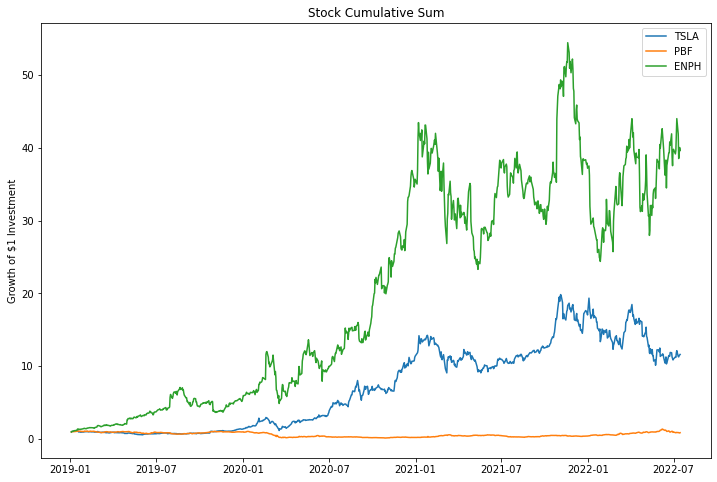

In [15]:
green_stocks_2 = stocks_df(green_stocks, start_date, end_date)
green_stocks_df2 = stocks_df(green_stocks, start_date, end_date)
graph_cumulative_return(green_stocks_df2)

In [20]:
stocks_df(green_stocks_list, start_date, end_date).head()

,DNNGY,IBDRY,JKS,GCTAY,TSLA,BEP,FSLR,REGI,ENPH,NEE,AMRC,TTE,ON,MP,STEM,SEDG,CEIX,PBF,CWEN
Date,,,,,,,,,,,,,,,,,,,
2019-01-02,20.543730,26.921341,10.19,2.453824,62.023998,12.334208,42.560001,26.010000,4.92,39.389626,14.07,42.000172,16.780001,NaN,NaN,36.150002,32.360001,31.833464,14.733716
2019-01-03,20.543730,27.056623,10.10,2.463799,60.071999,12.587265,43.439999,25.389999,4.76,39.292213,13.61,42.095650,15.650000,NaN,NaN,35.500000,31.490000,30.818810,14.562393
2019-01-04,21.193672,27.386374,10.93,2.463799,63.537998,12.990282,46.320000,26.070000,5.08,40.015846,14.54,43.328838,16.500000,NaN,NaN,37.250000,32.759998,32.155872,15.102057
2019-01-07,21.221933,27.656942,11.40,2.463799,66.991997,13.102754,45.790001,26.080000,5.26,39.957859,14.95,43.249279,17.000000,NaN,NaN,35.009998,32.439999,32.430874,14.493866
2019-01-08,21.221933,27.386374,11.47,2.553573,67.070000,13.182420,46.230000,26.559999,5.35,40.250103,15.07,43.114025,16.540001,NaN,NaN,35.000000,32.650002,31.757601,13.688648


TSLA
PBF
ENPH
Totals


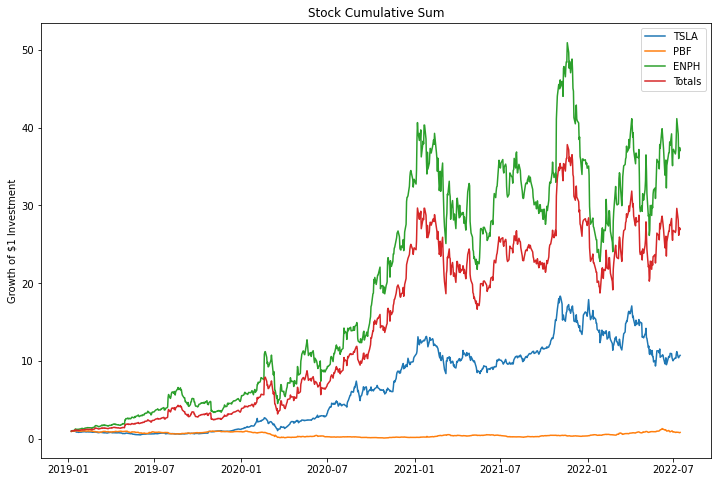

In [25]:
growth_1 = graph_cumulative_return(green_stocks_df.loc[:,['TSLA', 'PBF', 'ENPH', 'Totals']])

In [ ]:
# create a new function that visualizes the volatility vs. returns, color coded by sharpe ratio


 new function that takes in a dataframe with stocks and gives back the ideal combination of stocks with the optimal weight and highest mean return use these functions: make sure to use in this order*
 - optimal portfolio
 - portfolio performance
 - performance metrics 
 

In [27]:
import os
os.getcwd()

'/Users/macbookairair1313in/Desktop'